In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from cross_validation import CrossValidation 
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.ensemble import GradientBoostingRegressor as gbr
from sklearn.metrics import mean_squared_error

/Users/Priscilla/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
sp500_raw = pd.read_csv('SP500.csv')
pd.options.display.max_columns = sp500_raw.shape[1]
sp500_raw.head()

,Unnamed: 0,ticker,company_id,sector,industry,reported_as_of,filing_date,is_template_id,bs_template_id,revenue,cost_of_revenue,gross_profit,operating_income,operating_expense,non_operating_income,non_operating_expense,interest_income,interest_expense,non_interest_income,non_interest_expense,income_before_eq,income_before_min,taxes,income_incl_non_control,net_income,shares_outstanding_basic,shares_outstanding_diluted,current_assets,cash_and_equivalents,accounts_receivable,inventory,non_current_assets,goodwill,property_plant_and_equipment,intangible_assets,tangible_assets,assets,liabilities_current,accounts_payable_items,long_term_debt_current,liabilities_non_current,long_term_debt_non_current,total_debt,liabilities,stockholders_equity,retained_earnings,treasury_stock_value,earnings_per_share_diluted,debt_to_equity,book_value,return_on_capital,return_on_equity,operating_margin,working_capital,price,market_capitalization,price_to_revenue,price_to_earnings,price_to_books,price_to_tangible_assets,earnings_per_share,price_to_tangibles,z1_bancrupcy_score,eps_growth,valuation_mean,valuation_std,valuation_index
0,0,A,12981,Health Care,Health Care Equipment,2019-10-31,2019-12-19,1,2,5.163000e+09,2.358000e+09,2.805000e+09,941000000.0,1.864000e+09,919000000.0,74000000.0,NaN,NaN,NaN,NaN,919000000.0,919000000.0,-152000000.0,1.071000e+09,1.071000e+09,314000000.0,318000000.0,3.189000e+09,1.382000e+09,930000000.0,679000000.0,6.263000e+09,3.593000e+09,850000000.0,1.107000e+09,4.752000e+09,9.452000e+09,2.080000e+09,354000000.0,0.0,2.624000e+09,1.791000e+09,1.791000e+09,4.704000e+09,4.748000e+09,-1.800000e+07,NaN,3.367925,0.377211,4.748000e+09,0.163787,0.225569,0.182258,1.109000e+09,75.7500,2.408850e+10,4.665601,22.491597,5.073399,5.069129,3.367925,5.069129,4.077729,3.463846,35.0,25.0,0.462046
1,1,A,12981,Health Care,Health Care Equipment,2018-10-31,2018-12-20,1,2,4.914000e+09,2.227000e+09,2.687000e+09,928000000.0,1.759000e+09,946000000.0,75000000.0,NaN,NaN,NaN,NaN,946000000.0,946000000.0,630000000.0,3.160000e+08,3.160000e+08,321000000.0,325000000.0,3.848000e+09,2.247000e+09,776000000.0,638000000.0,4.693000e+09,2.973000e+09,822000000.0,4.910000e+08,5.077000e+09,8.541000e+09,1.171000e+09,340000000.0,0.0,2.799000e+09,1.799000e+09,1.799000e+09,3.970000e+09,4.571000e+09,-3.360000e+08,NaN,0.972308,0.393568,4.571000e+09,0.049608,0.069131,0.188848,2.677000e+09,64.2229,2.087244e+10,4.247546,66.052033,4.566275,4.111176,0.972308,4.111176,4.416415,0.463410,43.0,30.0,0.669543
2,2,A,12981,Health Care,Health Care Equipment,2017-10-31,2017-12-21,1,2,7.882000e+09,2.063000e+09,5.819000e+09,841000000.0,1.568000e+09,803000000.0,79000000.0,NaN,NaN,NaN,NaN,803000000.0,803000000.0,119000000.0,6.840000e+08,6.840000e+08,322000000.0,326000000.0,4.169000e+09,2.678000e+09,724000000.0,575000000.0,4.257000e+09,2.607000e+09,757000000.0,3.610000e+08,5.458000e+09,8.426000e+09,1.263000e+09,305000000.0,0.0,2.328000e+09,1.801000e+09,1.801000e+09,3.591000e+09,4.835000e+09,-1.260000e+08,NaN,2.098160,0.372492,4.835000e+09,0.103074,0.141468,0.106699,2.906000e+09,66.8275,2.178576e+10,2.763989,31.850534,4.505846,3.991529,2.098160,3.991529,5.282916,1.494144,33.0,30.0,0.493809
3,3,A,12981,Health Care,Health Care Equipment,2016-10-31,2016-12-20,1,2,7.429000e+09,2.005000e+09,5.424000e+09,615000000.0,1.582000e+09,544000000.0,72000000.0,NaN,NaN,NaN,NaN,544000000.0,544000000.0,82000000.0,4.620000e+08,4.620000e+08,326000000.0,329000000.0,3.635000e+09,2.289000e+09,631000000.0,533000000.0,4.159000e+09,2.517000e+09,639000000.0,4.160000e+08,4.861000e+09,7.794000e+09,9.450000e+08,257000000.0,0.0,2.603000e+09,1.904000e+09,1.904000e+09,3.548000e+09,4.246000e+09,6.089000e+09,1.050800e+10,1.404255,0.448422,4.246000e+09,0.075122,0.108808,0.082784,2.690000e+09,42.3885,1.394582e+10,1.877213,30.185750,3.284460,2.868919,1.404255,2.868919,5.049772,1.173131,22.0,15.0,0.519009
4,4,A,12981,Health Care,Health Care Equipment,2015-10-31,2015-12-21,1,2,7.184000e+09,1.997000e+09,5.187000e+09,522000000.0,1.519000e+09,

In [3]:
sp500_raw['reported_year'] = sp500_raw['reported_as_of'].apply(lambda x:int(x.split('-')[0]))
sp500 = []
for i, df in sp500_raw.groupby(['ticker']):
    sp500.append(df.sort_values(by=['reported_year']))
sp500 = pd.concat(sp500)
sp500 = sp500.drop(['Unnamed: 0'],axis =1)
# add a new feature to the dataframe to form the y variable (growth in income)
sp500['growth_change'] = sp500.groupby(by = ['company_id'])['net_income'].transform(lambda x: x.pct_change())

In [4]:
# Since 2011 is the first year, drop 2011 data
sp500 = sp500.drop(sp500[sp500['reported_year']==2011].index,axis = 0)
sp500.head(13)

,ticker,company_id,sector,industry,reported_as_of,filing_date,is_template_id,bs_template_id,revenue,cost_of_revenue,gross_profit,operating_income,operating_expense,non_operating_income,non_operating_expense,interest_income,interest_expense,non_interest_income,non_interest_expense,income_before_eq,income_before_min,taxes,income_incl_non_control,net_income,shares_outstanding_basic,shares_outstanding_diluted,current_assets,cash_and_equivalents,accounts_receivable,inventory,non_current_assets,goodwill,property_plant_and_equipment,...,assets,liabilities_current,accounts_payable_items,long_term_debt_current,liabilities_non_current,long_term_debt_non_current,total_debt,liabilities,stockholders_equity,retained_earnings,treasury_stock_value,earnings_per_share_diluted,debt_to_equity,book_value,return_on_capital,return_on_equity,operating_margin,working_capital,price,market_capitalization,price_to_revenue,price_to_earnings,price_to_books,price_to_tangible_assets,earnings_per_share,price_to_tangibles,z1_bancrupcy_score,eps_growth,valuation_mean,valuation_std,valuation_index,reported_year,growth_change
7,A,12981,Health Care,Health Care Equipment,2012-10-31,2012-12-20,1,2,1.251700e+10,3.254000e+09,9.263000e+09,1.119000e+09,2.485000e+09,1.043000e+09,101000000.0,NaN,NaN,NaN,NaN,1.043000e+09,1.043000e+09,-110000000.0,1.153000e+09,1.153000e+09,3.480000e+08,3.530000e+08,4.629000e+09,2.351000e+09,9.230000e+08,1.014000e+09,5.907000e+09,3.025000e+09,1.164000e+09,...,1.053600e+10,1.893000e+09,4.610000e+08,0.000000e+00,3.458000e+09,2.112000e+09,2.112000e+09,5.351000e+09,5.185000e+09,5.505000e+09,8.707000e+09,3.266289,0.407329,5.185000e+09,0.158010,0.222372,0.089398,2.736000e+09,24.2624,8.564627e+09,0.684240,7.428124,1.651809,1.333016,3.266289,1.333016,3.518151,1.145783,29.0,0.0,1.195265,2012,0.139328
6,A,12981,Health Care,Health Care Equipment,2013-10-31,2013-12-19,1,2,1.231600e+10,3.247000e+09,9.069000e+09,9.510000e+08,2.584000e+09,8.590000e+08,107000000.0,NaN,NaN,NaN,NaN,8.590000e+08,8.590000e+08,135000000.0,7.240000e+08,7.240000e+08,3.410000e+08,3.450000e+08,4.983000e+09,2.675000e+09,8.990000e+08,1.066000e+09,5.703000e+09,3.047000e+09,1.134000e+09,...,1.068600e+10,1.602000e+09,4.320000e+08,0.000000e+00,3.795000e+09,2.699000e+09,2.699000e+09,5.397000e+09,5.289000e+09,6.073000e+09,9.607000e+09,2.098551,0.510304,5.289000e+09,0.090636,0.136888,0.077217,3.381000e+09,34.5785,1.192958e+10,0.968625,16.477324,2.255546,1.774443,2.098551,1.774443,3.919368,0.642488,26.0,1.0,0.751912,2013,-0.372073
5,A,12981,Health Care,Health Care Equipment,2014-10-31,2014-12-22,1,2,1.266700e+10,3.388000e+09,9.279000e+09,8.310000e+08,2.762000e+09,6.460000e+08,113000000.0,NaN,NaN,NaN,NaN,6.460000e+08,6.460000e+08,142000000.0,5.040000e+08,5.040000e+08,3.330000e+08,3.380000e+08,5.509000e+09,2.218000e+09,6.260000e+08,5.740000e+08,5.306000e+09,2.507000e+09,6.310000e+08,...,1.081500e+10,1.692000e+09,3.020000e+08,0.000000e+00,3.819000e+09,1.663000e+09,1.663000e+09,5.511000e+09,5.304000e+09,6.469000e+09,9.807000e+09,1.491124,0.313537,5.304000e+09,0.072341,0.095023,0.065604,3.817000e+09,38.0097,1.284728e+10,1.014232,25.490632,2.422187,1.677409,1.491124,1.677409,4.028017,0.710550,14.0,2.0,0.368327,2014,-0.303867
4,A,12981,Health Care,Health Care Equipment,2015-10-31,2015-12-21,1,2,7.184000e+09,1.997000e+09,5.187000e+09,5.220000e+08,1.519000e+09,4.800000e+08,66000000.0,NaN,NaN,NaN,NaN,4.800000e+08,4.430000e+08,42000000.0,4.010000e+08,4.010000e+08,3.330000e+08,3.350000e+08,3.686000e+09,2.003000e+09,6.060000e+08,5.410000e+08,3.793000e+09,2.366000e+09,6.040000e+08,...,7.479000e+09,9.760000e+08,2.790000e+08,0.000000e+00,2.333000e+09,1.655000e+09,1.655000e+09,3.309000e+09,4.170000e+09,5.581000e+09,1.007400e+10,1.197015,0.396882,4.170000e+09,0.068841,0.096163,0.072661,2.710000e+09,36.3479,1.217655e+10,1.694954,30.365453,2.920035,2.608515,1.197015,2.608515,4.859775,0.802760,7.0,1.0,0.192583,2015,-0.204365
3,A,12981,Health Care,Health Care Equipment,2016-10-31,2016-12-20,1,2,7.429000e+09,2.0050

In [5]:
sp500[(sp500['reported_year']==2017)|(sp500['reported_year']==2018) | (sp500['reported_year']==2019)][['ticker','reported_year','growth_change']]

,ticker,reported_year,growth_change
2,A,2017,0.480519
1,A,2018,-0.538012
0,A,2019,2.389241
10,AA,2018,1.395522
9,AA,2019,-0.267913
16,AAL,2017,-0.282885
15,AAL,2018,-0.264200
14,AAL,2019,0.194051
24,AAP,2017,0.004451
23,AAP,2018,-0.108638


In [6]:
sp500['ticker'].nunique()

480

/Users/Priscilla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  


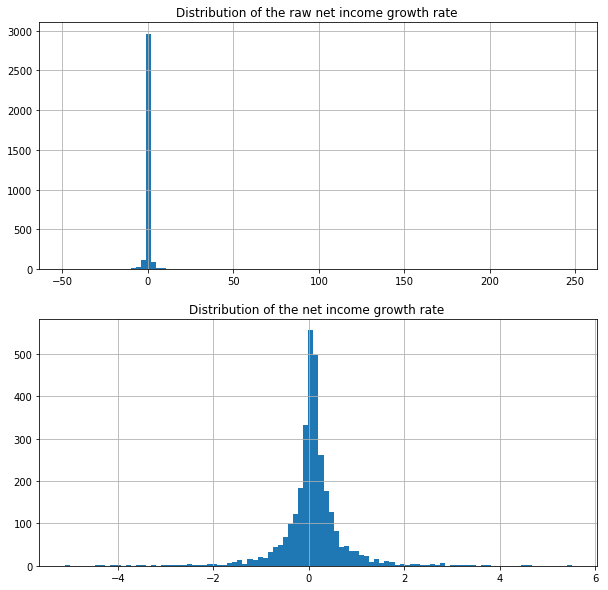

In [7]:

# See the distribution of the predicted variable
fig, axes = plt.subplots(nrows=2, ncols=1,figsize = (10,10))
sp500['growth_change'].hist(bins=100, ax=axes[0])
axes[0].set_title('Distribution of the raw net income growth rate ')
sp500['log_growth_change'] = np.log1p(sp500['growth_change'])
sp500['log_growth_change'].hist(bins=100, ax=axes[1])
axes[1].set_title('Distribution of the net income growth rate ')
plt.show()

/Users/Priscilla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/Priscilla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


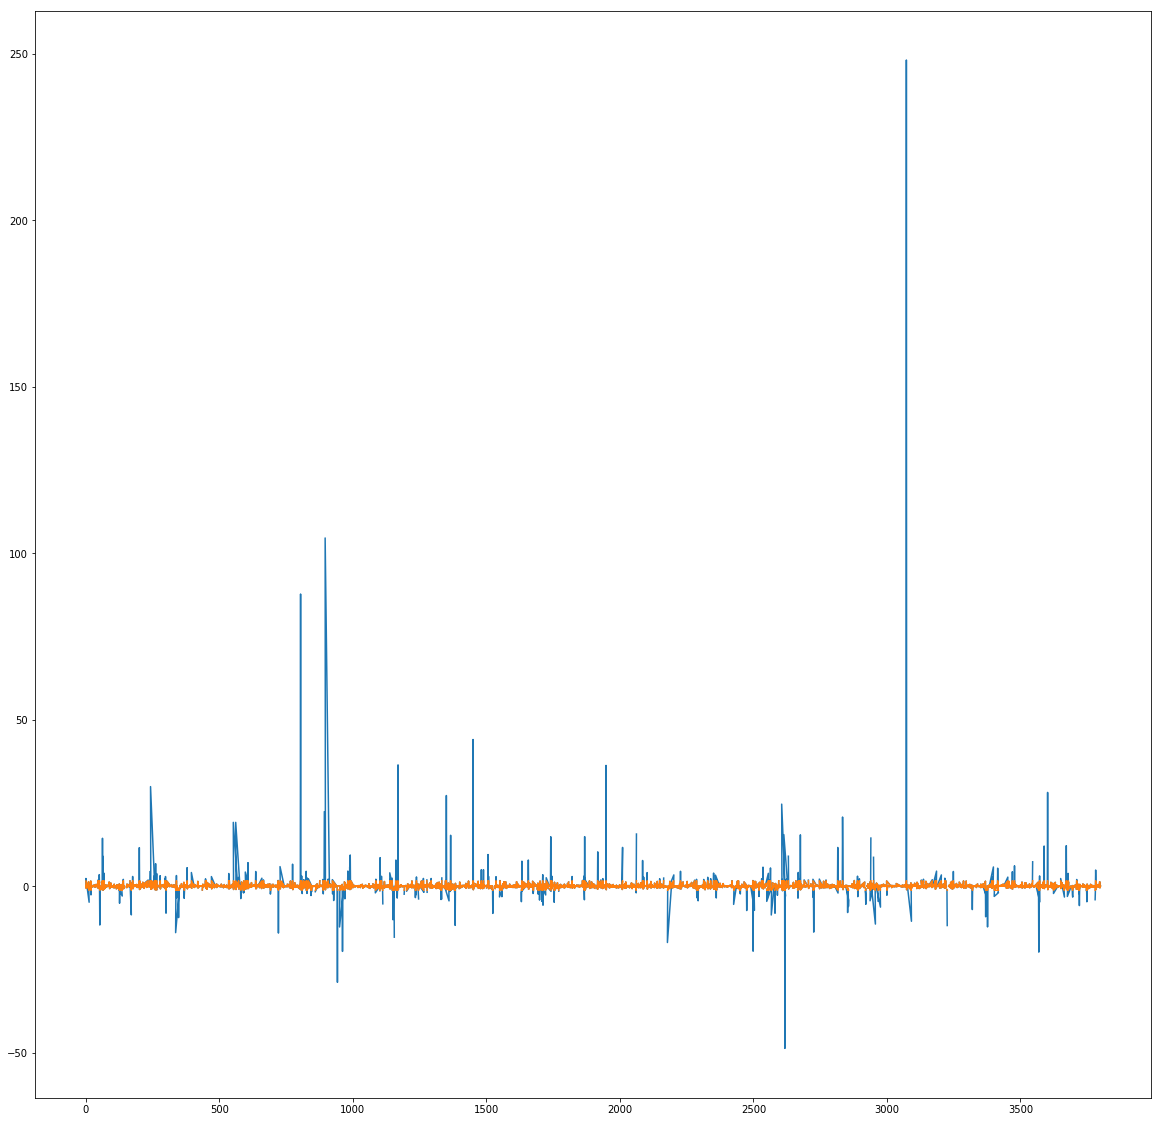

7       0.139328
6      -0.372073
5      -0.303867
4      -0.204365
3       0.152120
2       0.480519
1      -0.538012
0       1.702789
12     -1.134658
11     -1.117287
10      1.395522
9      -0.267913
20     -0.052046
19     -1.134658
18      1.640527
17     -0.648357
16     -0.282885
15     -0.264200
14      0.194051
29      0.120262
28      0.010545
27      0.260536
25     -0.069261
26      0.029972
24      0.004451
23     -0.108638
22      0.148754
39      0.609945
38     -0.112525
37      0.066771
          ...   
3762   -0.269581
3778    0.210766
3777   -0.316844
3776   -0.036664
3775    0.230257
3774    0.252127
3773   -0.172329
3772    0.150746
3771   -0.160830
3787   -0.007624
3786    0.007947
3785   -0.053745
3784   -0.795862
3783    1.080952
3782    1.702789
3781   -1.134658
3780   -1.134658
3793         NaN
3792   -0.223336
3791    0.515651
3790    0.262126
3789    0.493243
3801         NaN
3800    0.155963
3799    0.156746
3798   -0.418525
3797    1.421829
3796    0.0523

In [8]:
# Smoothing the data (remove outliers)
def quantile_clip(group):
    group.plot(figsize=(20, 20))
    group[group < group.quantile(.05)] = group.quantile(.05)
    group[group > group.quantile(.95)] = group.quantile(.95)
    group.plot()
    plt.show()
    return group

quantile_clip(sp500['growth_change'])

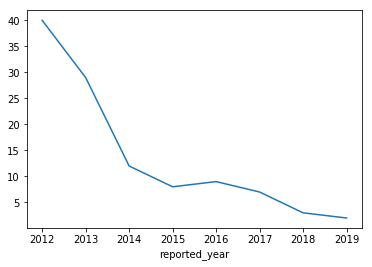

In [9]:
# Find missing data for all time period

# Add another column year to be used as group by object
sp500.loc[sp500['growth_change'].isnull() == True].groupby('reported_year')['company_id'].count().plot()

plt.show()

In [10]:
sp500.loc[sp500['growth_change'].isnull() == True].groupby('reported_year')['company_id'].count()

reported_year
2012    40
2013    29
2014    12
2015     8
2016     9
2017     7
2018     3
2019     2
Name: company_id, dtype: int64

## Feature Engineering

#Construct the dataset for modeling
#Drop the features that are intuitively unimportant
data = sp500.drop(['company_id','reported_as_of','is_template_id','bs_template_id'],axis =1)
year_string_dict ={"2012": "_2012","2013": "_2013","2014": "_2014","2015": "_2015","2016": "_2016",\
                  "2017":"_2017","2018":"_2018","2019":"_2019"}
def data_per_year(year_dict,year_int,df):
    df_year = df[df['reported_year']==year_int]
    df_year.columns = [str(col) + year_dict[str(year_int)] for col in df_year.columns]
    return df_year

#Segregate the companies according to years
data_2012 = data_per_year(year_string_dict,2012,data)
data_2013 = data_per_year(year_string_dict,2013,data)
data_2014 = data_per_year(year_string_dict,2014,data)
data_2015 = data_per_year(year_string_dict,2015,data)
data_2016 = data_per_year(year_string_dict,2016,data)
data_2017 = data_per_year(year_string_dict,2017,data)
data_2018 = data_per_year(year_string_dict,2018,data)
data_2019 = data_per_year(year_string_dict,2019,data)

#Concat the data on axis =1 to get the combo fixture from the past 2 years
target_2014 = pd.concat([data_2012,data_2013],axis = 1).drop(['sector_2013','industry_2013'],axis =1)
target_2015 = pd.concat([data_2013,data_2014],axis = 1).drop(['sector_2014','industry_2014'],axis =1)
target_2016 = pd.concat([data_2014,data_2015],axis = 1).drop(['sector_2015','industry_2015'],axis =1)
target_2017 = pd.concat([data_2015,data_2016],axis = 1).drop(['sector_2016','industry_2016'],axis =1) # Test set

In [11]:
data = sp500.drop(['company_id','reported_as_of','is_template_id','bs_template_id'],axis =1)
data_ = data.copy()
data_shift = data_.copy()
y_shift = data_.copy()
shift = 1
shift_y = 2
data_shift['reported_year'] = data_shift['reported_year']+shift
y_shift['reported_year'] = y_shift['reported_year']-shift_y

In [12]:
index_columns = ['ticker', 'reported_year']
print(f'Size before merge: {data_.shape}')
data_merged = data_shift.set_index(index_columns).join(data_.set_index(index_columns),how = 'inner',rsuffix = '_n+1').reset_index()
data_merged.set_index(index_columns)
# Adjust to the target year
data_merged['reported_year'] = data_merged['reported_year']+1
print(f'Size after merge: {data_merged.shape}')

print(f'y Size before merge: {y_shift.shape}')
y_merged = data_.set_index(index_columns).join(y_shift.set_index(index_columns),how = 'inner',rsuffix = '_n+2').reset_index()
y_merged.set_index(index_columns)
# Adjust to the  target year
y_merged['reported_year'] = y_merged['reported_year']+2
print(f'Size after merge: {y_merged.shape}')

# pd.options.display.max_columns = data_merged.shape[1]
# display(data_merged.head())
# display(y_merged.head())

Size before merge: (3380, 65)
Size after merge: (2838, 128)
y Size before merge: (3380, 65)
Size after merge: (2372, 128)


In [13]:
dataset = data_merged.set_index(['ticker', 'reported_year']).join(y_merged.set_index(['ticker', 'reported_year'])[["growth_change_n+2"]], how="left").reset_index()
X_train = dataset[(dataset['reported_year'] >=2014) & (dataset['reported_year'] <= 2018)].T.drop_duplicates().T.drop('growth_change_n+2',axis = 1)
y_train = dataset[(dataset['reported_year'] >=2014) & (dataset['reported_year'] <= 2018)]['growth_change_n+2']
X_test = dataset[dataset['reported_year'] == 2019].T.drop_duplicates().T.drop('growth_change_n+2',axis = 1)
y_test = dataset[dataset['reported_year'] == 2019]['growth_change_n+2']

In [14]:
X_train[['growth_change', 'growth_change_n+1']].join(y_train).head(10)
#print(X_test.shape)

,growth_change,growth_change_n+1,growth_change_n+2
0,0.139328,-0.372073,-0.303867
1,-0.372073,-0.303867,-0.204365
2,-0.303867,-0.204365,0.152120
3,-0.204365,0.15212,0.480519
4,0.15212,0.480519,-0.538012
7,-1.13466,-1.11729,NaN
9,-1.13466,1.64053,-0.648357
10,1.64053,-0.648357,-0.282885
11,-0.648357,-0.282885,-0.264200
14,0.120262,0.0105451,NaN


In [15]:
X_test[['growth_change', 'growth_change_n+1']].join(y_test).head(10)

,growth_change,growth_change_n+1,growth_change_n+2
5,0.480519,-0.538012,1.702789
12,-0.282885,-0.2642,0.194051
21,0.0044508,-0.108638,0.148754
28,0.0583098,0.231226,-0.071811
35,-0.108181,0.0711998,0.385968
42,-0.744746,1.70279,-0.484224
49,0.366189,1.15231,1.309138
53,-0.791156,1.70279,0.557010
60,-0.16215,0.178442,0.177148
67,0.449333,0.529424,0.139219


## Encoding categorical data


In [16]:
cat_cols = ['sector','industry']
cat = pd.get_dummies(dataset[cat_cols])
# cat_train =pd.get_dummies(X_train[cat_cols])
# cat_test = pd.get_dummies(X_test[cat_cols])

## Selecting numerical data

In [17]:
# Numerical data selection, drop the columns with 50%+ null data
col_drop = []
for col in dataset.columns:
    if dataset[col].isnull().sum()/len(dataset[col])>=0.3:
        col_drop.append(col)
dataset.drop(col_drop,axis =1)
print(col_drop)

['interest_income', 'interest_expense', 'non_interest_income', 'non_interest_expense', 'intangible_assets', 'treasury_stock_value', 'interest_income_n+1', 'interest_expense_n+1', 'non_interest_income_n+1', 'non_interest_expense_n+1', 'intangible_assets_n+1', 'treasury_stock_value_n+1']


In [19]:
num_drop = cat_cols+col_drop+['filing_date','filing_date_n+1','reported_year']
X_train_num = X_train.drop(num_drop,axis =1).fillna(-99)
X_test_num = X_test.drop(num_drop,axis = 1).fillna(-99)
X_Train = pd.merge(cat, X_train_num, left_index=True, right_index=True)
y_train = y_train.fillna(-99)
y_test = y_test.fillna(-99)
X_test = pd.merge(cat, X_test_num, left_index=True, right_index=True)

# Modeling

In [30]:
rfrpara = {'n_estimators': list(range(90,120,5)),'max_depth': list(range(45,65,3)),'min_samples_leaf': [1, 2]}
cv_rfr = CrossValidation(estimator = rfr(),X = X_Train.drop('ticker',axis =1), y = y_train, param_grid = rfrpara)
rfr_splits = cv_rfr.get_grouped_cv_splits(n_splits = 5, groups = X_Train['ticker'])
rfr_model, feature_importance,best_cv_score = cv_rfr.grid_search(cv=rfr_splits, verbose=1, path=os.path.join(os.getcwd(),'rfr_result.csv'))

Running grid search...
Fitting 5 folds for each of 84 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 33.3min
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed: 71.5min finished


In [31]:
y_predict = rfr_model.predict(X_Train.drop("ticker",axis = 1))

In [32]:
from sklearn.metrics import mean_squared_error,r2_score
print(f'The R2_score of best random forest model from CV is: {rfr_model.score(X_Train.drop("ticker",axis = 1),y_train)}')
print(f'The MSE of best random forest model from CV is: {mean_squared_error(y_train,y_predict)}')

The R2_score of best random forest model from CV is: 0.7396242587601809
The MSE of best random forest model from CV is: 123.58878198224141


In [33]:
def get_feature_score(columns,score):    
    df_feature_score =pd.concat([columns, score],axis = 1)
    df_feature_score.columns = ['feature','score']
    df_feature_score = df_feature_score.sort_values("score",ascending = False)
    return df_feature_score.head(5)
rfr_feature_score = get_feature_score(pd.DataFrame(X_Train.drop('ticker',axis = 1).columns),pd.DataFrame(feature_importance))
rfr_feature_score

,feature,score
240,growth_change_n+1,0.075725
148,income_before_min,0.022212
227,operating_margin_n+1,0.021882
176,operating_margin,0.020765
236,eps_growth_n+1,0.018563


In [36]:
y_test_predict = rfr_model.predict(X_test.drop('ticker',axis = 1))
print(f'The r2 score for random forest testing is {r2_score(y_test,y_test_predict)}')
print(f'The MSE for random forest testing is {mean_squared_error(y_test,y_test_predict)}')

The r2 score for random forest testing is -0.03825643549491753
The MSE for random forest testing is 1194.0328847906064


In [37]:
gbrhyperpara = {'n_estimators': list(range(90,120,5)),'max_depth': list(range(4,15,3)),'min_samples_leaf': [1, 2]}
cv_gbr = CrossValidation(estimator = gbr(),X = X_Train.drop('ticker',axis =1), y = y_train, param_grid = gbrhyperpara)
gbr_splits = cv_gbr.get_grouped_cv_splits(n_splits = 5, groups = X_Train['ticker'])
gbr_model,gbr_feature_importance,best_cv_gbe_score = cv_gbr.grid_search(cv=gbr_splits, verbose=1, path=os.path.join(os.getcwd(),'gbr_result.csv'))


Running grid search...
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 10.4min finished


In [38]:
y_test_predict_gbr = gbr_model.predict(X_test.drop('ticker',axis = 1))
r2_score(y_test,y_test_predict_gbr)
mean_squared_error(y_test,y_test_predict_gbr)
print(f'The r2 score for gradient boosting testing is {r2_score(y_test,y_test_predict_gbr)}')
print(f'The MSE for gradient boosting testing is {mean_squared_error(y_test,y_test_predict_gbr)}')

The r2 score for gradient boosting testing is -0.08004214745609595
The MSE for gradient boosting testing is 1242.0879822504662


In [39]:
gbr_feature_score = get_feature_score(pd.DataFrame(X_Train.drop('ticker',axis = 1).columns),pd.DataFrame(gbr_feature_importance))
gbr_feature_score

,feature,score
240,growth_change_n+1,0.051217
236,eps_growth_n+1,0.031850
232,price_to_earnings_n+1,0.029592
181,price_to_earnings,0.023290
190,log_growth_change,0.022028


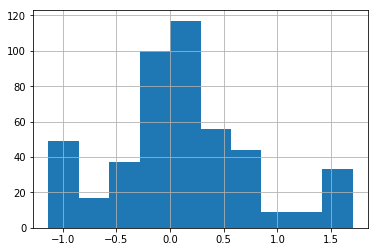

In [27]:
y_test[(y_test>-3) & (y_test<3)].hist()